In [ ]:
%pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PowerTransformer
from sklearn.feature_selection import SelectKBest,RFE,SelectFromModel,f_regression,VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,learning_curve
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier,GradientBoostingRegressor, GradientBoostingClassifier,
                                StackingRegressor,VotingRegressor, VotingClassifier)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor, MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from imblearn.pipeline import Pipeline as ImbPipeline
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2


In [3]:
df = pd.read_csv('/content/Student_performance_data.csv')
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [4]:
df.shape

(2392, 15)

In [5]:
df.columns.tolist()

['StudentID',
 'Age',
 'Gender',
 'Ethnicity',
 'ParentalEducation',
 'StudyTimeWeekly',
 'Absences',
 'Tutoring',
 'ParentalSupport',
 'Extracurricular',
 'Sports',
 'Music',
 'Volunteering',
 'GPA',
 'GradeClass']

In [6]:
df.dtypes

,0
StudentID,int64
Age,int64
Gender,int64
Ethnicity,int64
ParentalEducation,int64
StudyTimeWeekly,float64
Absences,int64
Tutoring,int64
ParentalSupport,int64
Extracurricular,int64


**Data Preprocessing Pipeline**

In [7]:
numeric_features = ['Age', 'StudyTimeWeekly', 'Absences', 'ParentalSupport']
categorical_features = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

target_reg = 'GPA'
target_cls = 'GradeClass'
id_column = 'StudentID'

In [8]:
def engineer_features(X):
    X = df.copy()
    X['TotalExtracurricular'] = X[['Extracurricular', 'Sports', 'Music', 'Volunteering']].sum(axis=1)
    X['StudyEfficiency'] = X['StudyTimeWeekly'] / (X['Absences'] + 1)
    X['SupportScore'] = X['ParentalSupport'] * X['ParentalEducation'] / 4.0

    X['TutoringImpact'] = X['Tutoring'] * X['StudyTimeWeekly'] / 10.0
    X['Study_ParentSupport'] = X['StudyTimeWeekly'] * X['ParentalSupport']
    X['Age_Study'] = X['Age'] * X['StudyTimeWeekly']

    X['Absence_Performance'] = X['Absences'] * X['ParentalEducation']
    X['Tutoring_Support'] = X['Tutoring'] * X['ParentalSupport']

    X['StudyTime_squared'] = X['StudyTimeWeekly'] ** 2
    X['Absences_squared'] = X['Absences'] ** 2
    X['StudyTime_sqrt'] = np.sqrt(X['StudyTimeWeekly'] + 0.1)
    X['Absences_log'] = np.log1p(X['Absences'])

    return X

In [9]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [10]:
numeric_features = ['Age', 'StudyTimeWeekly', 'Absences', 'ParentalSupport']
categorical_features = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

In [11]:
target_reg = 'GPA'
target_cls = 'GradeClass'
id_column = 'StudentID'

**Exploratory Data Analysis**

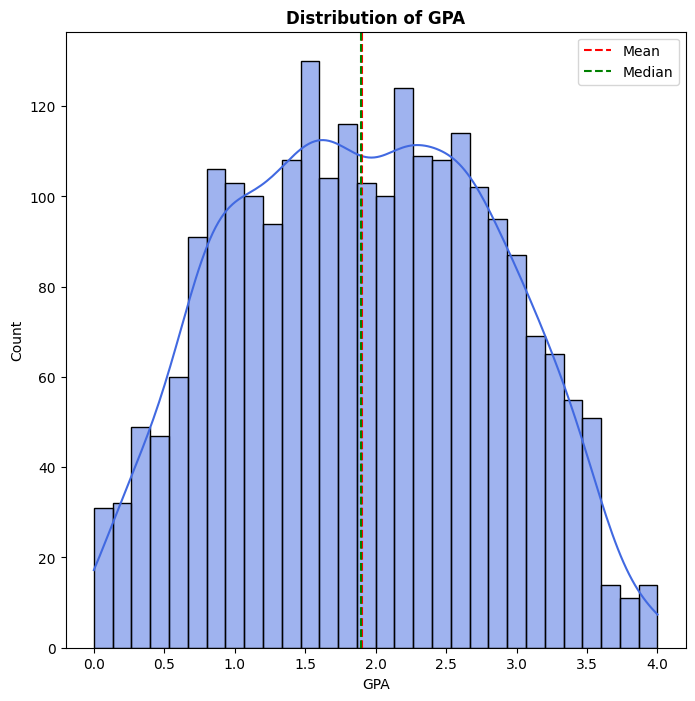

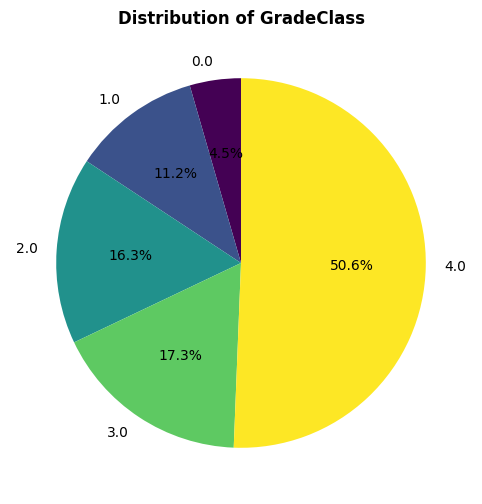

In [12]:
plt.figure(figsize=(8,8))
sns.histplot(df[target_reg], kde=True, bins=30, color='royalblue')
plt.axvline(df[target_reg].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df[target_reg].median(), color='green', linestyle='--', label='Median')
plt.title(f'Distribution of {target_reg}', fontweight='bold')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
class_counts = df[target_cls].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))
wedges, texts, autotexts = plt.pie(class_counts.values, labels=class_counts.index,colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of {target_cls}', fontweight='bold')
plt.show()

Text(0.5, 1.0, 'Feature Correlation Matrix')

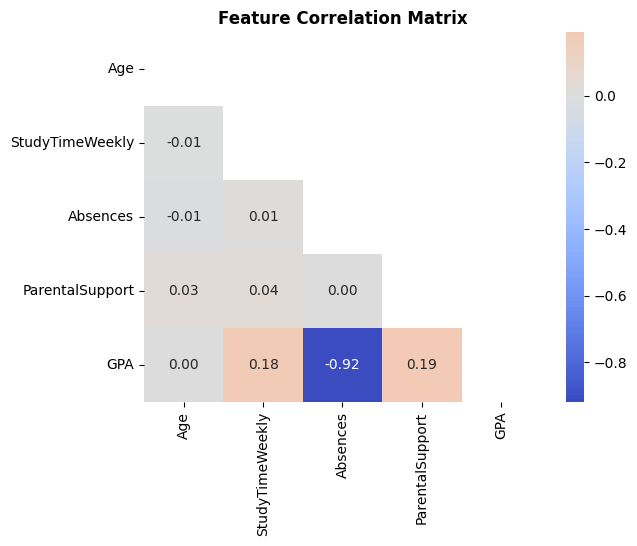

In [13]:
all_numeric = numeric_features + [target_reg]
corr_matrix = df[all_numeric].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontweight='bold')

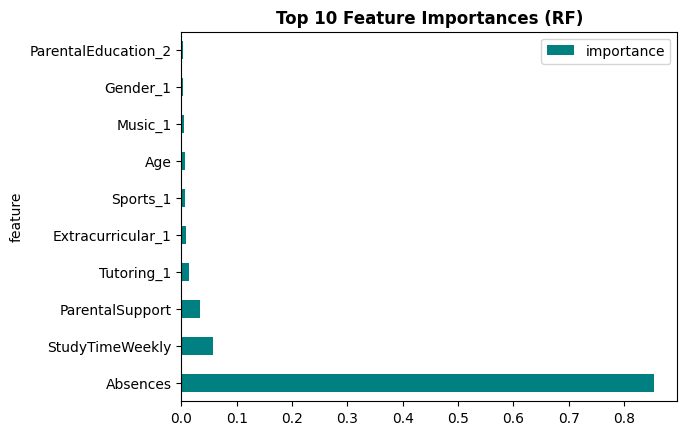

In [14]:
X_temp = df[numeric_features + categorical_features].copy()
X_temp = pd.get_dummies(X_temp, columns=categorical_features, drop_first=True)
y_temp = df[target_reg]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
importances = pd.DataFrame({
        'feature': X_temp.columns,
        'importance': rf.feature_importances_
 }).sort_values('importance', ascending=False).head(10)

importances.plot(kind='barh', x='feature', y='importance', color='teal')
plt.title('Top 10 Feature Importances (RF)', fontweight='bold')
plt.savefig('featureimportance.png')
plt.show()


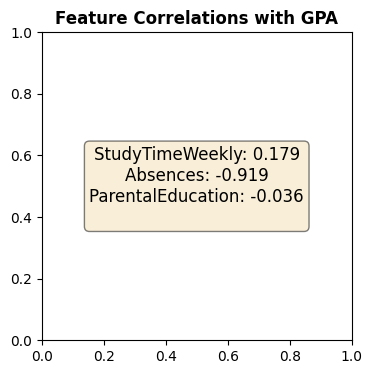

In [15]:
plt.figure(figsize=(4,4))
key_features = ['StudyTimeWeekly', 'Absences', 'ParentalEducation', target_reg]
pair_data = df[key_features]
corr_text = ''
for feat in key_features[:-1]:
    corr = df[feat].corr(df[target_reg])
    corr_text += f'{feat}: {corr:.3f}\n'
plt.text(0.5, 0.5, corr_text,
             fontsize=12, va='center', ha='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('Feature Correlations with GPA', fontweight='bold')
plt.show()

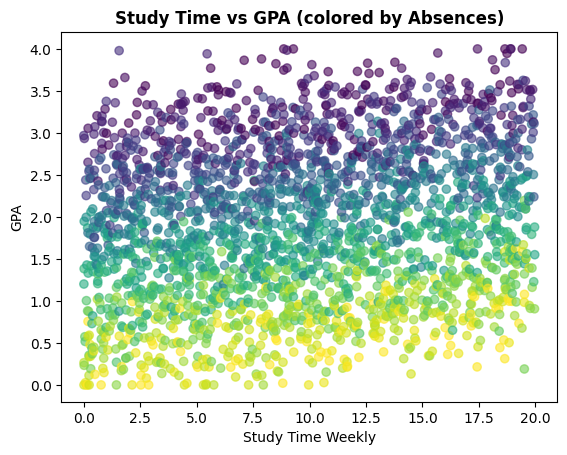

In [16]:
df_sorted = df.sort_values('StudyTimeWeekly')
plt.scatter(df_sorted['StudyTimeWeekly'], df_sorted[target_reg],
            alpha=0.6, c=df_sorted['Absences'], cmap='viridis')
plt.xlabel('Study Time Weekly')
plt.ylabel('GPA')
plt.title('Study Time vs GPA (colored by Absences)', fontweight='bold')
plt.show()

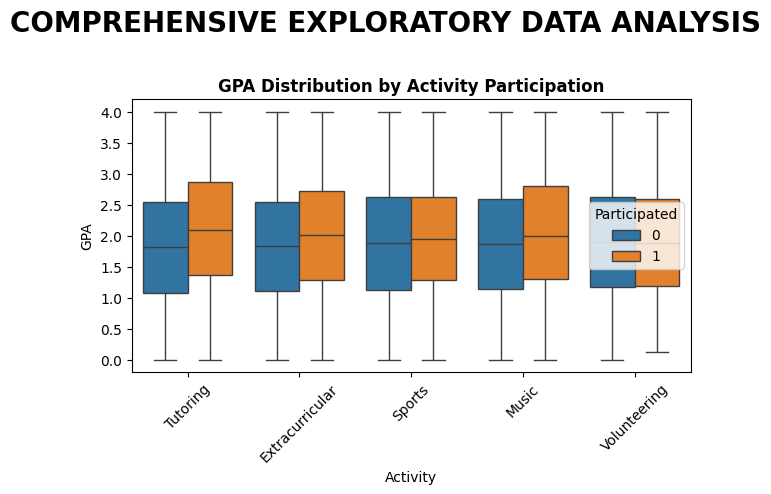

In [17]:
categorical_for_plot = ['Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
melted_data = df.melt(id_vars=[target_reg], value_vars=categorical_for_plot,var_name='Activity', value_name='Participated')
sns.boxplot(x='Activity', y=target_reg, hue='Participated',data=melted_data)
plt.title('GPA Distribution by Activity Participation', fontweight='bold')
plt.tick_params(axis='x', rotation=45)

plt.suptitle('COMPREHENSIVE EXPLORATORY DATA ANALYSIS',fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
print("Top correlation with GPA:")
correlations = df[numeric_features].corrwith(df[target_reg]).sort_values(ascending=False)
for feat, corr in correlations.items():
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    print(f"   {feat}: {corr:.3f} ({strength})")

Top correlation with GPA:
   ParentalSupport: 0.191 (Weak)
   StudyTimeWeekly: 0.179 (Weak)
   Age: 0.000 (Weak)
   Absences: -0.919 (Strong)


In [19]:
print("Group Differences (T-test):")
for cat_feat in ['Tutoring', 'Music', 'Sports']:
    group1 = df[df[cat_feat] == 1][target_reg]
    group0 = df[df[cat_feat] == 0][target_reg]
    t_stat, p_value = stats.ttest_ind(group1, group0, equal_var=False)
    print(f"   {cat_feat}: t={t_stat:.2f}, p={p_value:.4f} {'*' if p_value < 0.05 else ''}")

Group Differences (T-test):
   Tutoring: t=7.17, p=0.0000 *
   Music: t=3.60, p=0.0003 *
   Sports: t=2.85, p=0.0044 *


In [20]:
X = df.drop([target_reg, target_cls, id_column], axis=1)
y_reg = df[target_reg]
y_cls = df[target_cls]

In [21]:
X.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
0,17,1,0,2,19.833723,7,1,2,0,0,1,0
1,18,0,0,1,15.408756,0,0,1,0,0,0,0
2,15,0,2,3,4.210570,26,0,2,0,0,0,0
3,17,1,0,3,10.028829,14,0,3,1,0,0,0
4,17,1,0,2,4.672495,17,1,3,0,0,0,0


In [22]:
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    X, y_reg, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

In [23]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson'))
])

In [24]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [26]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all'))
])

In [27]:
X_train_processed = full_pipeline.fit_transform(X_train, y_train_reg)
X_test_processed = full_pipeline.transform(X_test)

In [28]:
feature_names = []
feature_names.extend(numeric_features)

cat_encoder = full_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
feature_names.extend(cat_features)

feature_names.extend(['TotalExtracurricular', 'StudyEfficiency', 'SupportScore', 'TutoringImpact', 'Study_ParentSupport', 'Age_Study',
                'Absence_Performance', 'Tutoring_Support','StudyTime_squared', 'Absences_squared','StudyTime_sqrt', 'Absences_log'])

In [29]:
X_train.shape[1], X_train_processed.shape[1]

(12, 25)

In [30]:
feature_selection_methods = {
    'VarianceThreshold': VarianceThreshold(threshold=0.01),
    'SelectKBest': SelectKBest(score_func=f_regression, k=15),
    'RFE': RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), n_features_to_select=10),
    'SelectFromModel': SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')}

In [31]:
selected_features_dict = {}
for method_name, selector in feature_selection_methods.items():
    print(method_name)
    X_train_selected = selector.fit_transform(X_train_processed, y_train_reg)
    X_test_selected = selector.transform(X_test_processed)

    if hasattr(selector, 'get_support'):
        selected_indices = selector.get_support()
        selected_features = [feature_names[i] for i in range(len(selected_indices)) if selected_indices[i]]
    else:
        selected_features = [f"Feature_{i}" for i in range(X_train_selected.shape[1])]

    selected_features_dict[method_name] = {
        'X_train': X_train_selected,
        'X_test': X_test_selected,
        'features': selected_features,
        'n_features': X_train_selected.shape[1]
    }

    print(f"Selected {X_train_selected.shape[1]} features")

VarianceThreshold
Selected 25 features
SelectKBest
Selected 15 features
RFE
Selected 10 features
SelectFromModel
Selected 13 features


In [32]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)
print(f"PCA: Reduced to {X_train_pca.shape[1]} components (95% variance)")

PCA: Reduced to 14 components (95% variance)


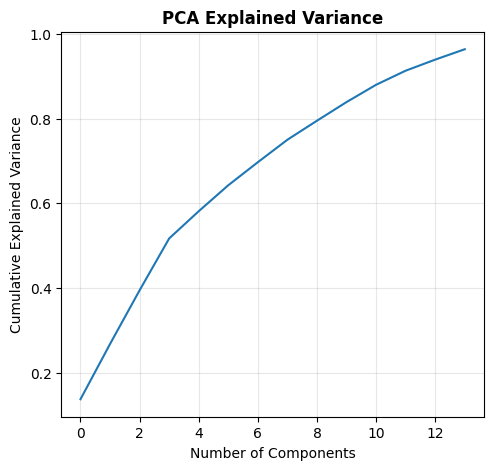

In [33]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance', fontweight='bold')
plt.grid(True, alpha=0.3)

In [34]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_processed[:1000])

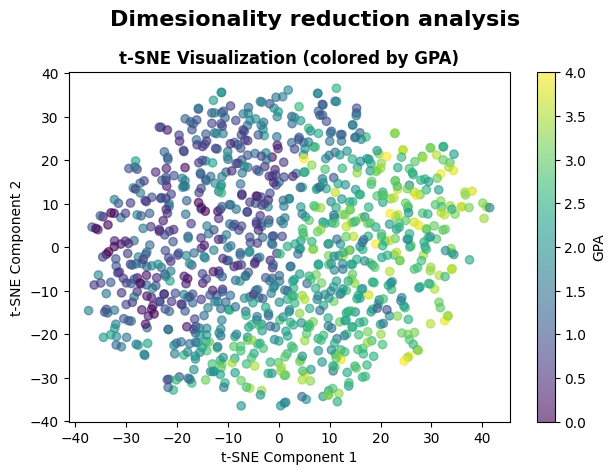

In [35]:

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
            c=y_train_reg.values[:1000], cmap='viridis', alpha=0.6)
plt.colorbar(label='GPA')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization (colored by GPA)', fontweight='bold')

plt.suptitle('Dimesionality reduction analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('dimensionality_reduction.png', dpi=300, bbox_inches='tight')
plt.show()

**Model Training Pipeline**

In [36]:
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127],
        'subsample': [0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5]
    },

    'LinearRegression': {
        'fit_intercept': [True, False]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0]
    },
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.25, 0.5, 0.75]
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['liblinear', 'saga']
    },

    'GradientBoosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    },

    'SVR': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear']
    },

    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01]
    }
}

In [37]:
regression_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=0),
}

In [38]:
classification_models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=0),
}

In [39]:
def tune_and_evaluate_models(X_train, X_test, y_train, y_test, models_dict,param_grids_dict, problem_type='regression'):

    results = []
    best_models = {}

    for model_name, model in models_dict.items():
        print(f"\n{'='*60}")
        print(f"TUNING {model_name.upper()}")
        print(f"{'='*60}")

        cv_scores = cross_val_score(model, X_train, y_train,
                        cv=5,
                        scoring='r2' if problem_type == 'regression' else 'accuracy',
                        n_jobs=-1)

        print(f"CV Scores: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

        grid_search = RandomizedSearchCV(
            model,
            param_grids_dict[model_name],
            n_iter=20,
            cv=3,
            scoring='r2' if problem_type == 'regression' else 'accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        print(f"Best Params: {best_params}")
        print(f"Best CV Score: {best_score:.4f}")

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        if problem_type == 'regression':
            metrics = {
                'Train_R2': r2_score(y_train, y_pred_train),
                'Test_R2': r2_score(y_test, y_pred_test),
                'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
                'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
                'Train_MAE': mean_absolute_error(y_train, y_pred_train),
                'Test_MAE': mean_absolute_error(y_test, y_pred_test)
            }
        else:
            metrics = {
                'Train_Accuracy': accuracy_score(y_train, y_pred_train),
                'Test_Accuracy': accuracy_score(y_test, y_pred_test),
                'Train_F1': f1_score(y_train, y_pred_train, average='weighted'),
                'Test_F1': f1_score(y_test, y_pred_test, average='weighted')
            }

        result = {
            'Model': model_name,
            'CV_Score': best_score,
            'CV_Std': cv_scores.std(),
            **metrics,
            'Best_Params': best_params
        }

        results.append(result)
        best_models[model_name] = best_model

        print(f"Test Performance: {metrics}")

    return pd.DataFrame(results), best_models


In [40]:
reg_results_df, reg_best_models = tune_and_evaluate_models(
    X_train_processed, X_test_processed,
    y_train_reg, y_test_reg,
    regression_models, param_grids,
    problem_type='regression'
)


TUNING LINEARREGRESSION
CV Scores: 0.9537 (±0.0032)
Best Params: {'fit_intercept': True}
Best CV Score: 0.9536
Test Performance: {'Train_R2': 0.9547319423658058, 'Test_R2': 0.9501614295946806, 'Train_RMSE': np.float64(0.19635549364467372), 'Test_RMSE': np.float64(0.1968400598224804), 'Train_MAE': 0.15822017126706953, 'Test_MAE': 0.1592840576204484}

TUNING RIDGE
CV Scores: 0.9537 (±0.0031)
Best Params: {'alpha': 1.0}
Best CV Score: 0.9536
Test Performance: {'Train_R2': 0.9547316229828234, 'Test_R2': 0.9501908199982801, 'Train_RMSE': np.float64(0.19635618632396937), 'Test_RMSE': np.float64(0.1967820117895107), 'Train_MAE': 0.15821799231131148, 'Test_MAE': 0.15924244982428307}

TUNING LASSO
CV Scores: -0.0035 (±0.0037)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'alpha': 0.001}
Best CV Score: 0.9537
Test Performance: {'Train_R2': 0.9546302653591273, 'Test_R2': 0.9503003410014891, 'Train_RMSE': np.float64(0.19657588790998445), 'Test_RMSE': np.float64(0.19656554944809657), 'Train_MAE': 0.158366875398622, 'Test_MAE': 0.15916521474353126}

TUNING ELASTICNET
CV Scores: 0.3994 (±0.0118)
Best Params: {'l1_ratio': 0.25, 'alpha': 0.1}
Best CV Score: 0.9263
Test Performance: {'Train_R2': 0.9270539382848626, 'Test_R2': 0.9263790473743188, 'Train_RMSE': np.float64(0.249257394659585), 'Test_RMSE': np.float64(0.23923869048988472), 'Train_MAE': 0.19927262957322192, 'Test_MAE': 0.19255911463485503}

TUNING RANDOMFOREST


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CV Scores: 0.9304 (±0.0059)
Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best CV Score: 0.9292
Test Performance: {'Train_R2': 0.9909293386661999, 'Test_R2': 0.9191039291743603, 'Train_RMSE': np.float64(0.0878954922153842), 'Test_RMSE': np.float64(0.2507808755386375), 'Train_MAE': 0.06919084450618601, 'Test_MAE': 0.20142241879208303}

TUNING GRADIENTBOOSTING
CV Scores: 0.9485 (±0.0028)
Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best CV Score: 0.9488
Test Performance: {'Train_R2': 0.9624367293966627, 'Test_R2': 0.942078055154549, 'Train_RMSE': np.float64(0.17886642460010402), 'Test_RMSE': np.float64(0.21220336580773977), 'Train_MAE': 0.14227650386669172, 'Test_MAE': 0.16811453502316828}

TUNING XGBOOST
CV Scores: 0.9320 (±0.0043)
Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV Score: 0.9492
Test Performance: {'

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV Scores: 0.9483 (±0.0025)
Best Params: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}
Best CV Score: 0.9522
Test Performance: {'Train_R2': 0.9586933000246147, 'Test_R2': 0.9464225196748344, 'Train_RMSE': np.float64(0.18756740783158), 'Test_RMSE': np.float64(0.20409005510349587), 'Train_MAE': 0.15056602249956125, 'Test_MAE': 0.1641909986497446}


In [41]:
cls_results_df, cls_best_models = tune_and_evaluate_models(
    X_train_processed, X_test_processed,
    y_train_cls, y_test_cls,
    classification_models, param_grids,
    problem_type='classification'
)


TUNING LOGISTICREGRESSION
CV Scores: 0.7115 (±0.0065)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'solver': 'saga', 'C': 100.0}
Best CV Score: 0.6999
Test Performance: {'Train_Accuracy': 0.7459487715629901, 'Test_Accuracy': 0.7202505219206681, 'Train_F1': 0.7273486701619389, 'Test_F1': 0.711184109433149}

TUNING RANDOMFOREST
CV Scores: 0.6947 (±0.0093)
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best CV Score: 0.7047
Test Performance: {'Train_Accuracy': 0.9221118661787768, 'Test_Accuracy': 0.6931106471816284, 'Train_F1': 0.9201683317846073, 'Test_F1': 0.6790200605587641}

TUNING GRADIENTBOOSTING
CV Scores: 0.7109 (±0.0178)
Best Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
Best CV Score: 0.7141
Test Performance: {'Train_Accuracy': 1.0, 'Test_Accuracy': 0.6868475991649269, 'Train_F1': 1.0, 'Test_F1': 0.6861323916183641}

TUNING XGBOOST
CV Scores: 0.7125 (±0.0262)
Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Performance: {'Train_Accuracy': 0.8677469942498693, 'Test_Accuracy': 0.7056367432150313, 'Train_F1': 0.86556848354839, 'Test_F1': 0.7048835304374766}

TUNING CATBOOST
CV Scores: 0.7214 (±0.0119)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 6}
Best CV Score: 0.7308
Test Performance: {'Train_Accuracy': 0.8787245164662834, 'Test_Accuracy': 0.7286012526096033, 'Train_F1': 0.8765260867484213, 'Test_F1': 0.7259379127217771}


**Ensemble Learning and Stacking**

In [42]:
ensemble_regressor = VotingRegressor([
    ('rf', reg_best_models.get('RandomForest', RandomForestRegressor(random_state=42))),
    ('xgb', reg_best_models.get('XGBoost', xgb.XGBRegressor(random_state=42, verbosity=0))),
    ('lgbm', reg_best_models.get('LightGBM', lgb.LGBMRegressor(random_state=42, verbose=-1))),
    ('catboost', reg_best_models.get('CatBoost', cb.CatBoostRegressor(random_state=42, verbose=0)))
])

In [43]:
ensemble_classifier = VotingClassifier([
    ('rf', cls_best_models.get('RandomForest', RandomForestClassifier(random_state=42))),
    ('xgb', cls_best_models.get('XGBoost', xgb.XGBClassifier(random_state=42, verbosity=0))),
    ('lgbm', cls_best_models.get('LightGBM', lgb.LGBMClassifier(random_state=42, verbose=-1))),
    ('catboost', cls_best_models.get('CatBoost', cb.CatBoostClassifier(random_state=42, verbose=0)))
], voting='soft')

In [44]:
ensemble_regressor.fit(X_train_processed, y_train_reg)
ensemble_classifier.fit(X_train_processed, y_train_cls)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_type...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.01, max_depth=15,
                                             n_estimators=200, random_state=42,
                                             subsample=0.8, verbose=-1)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7bc5745cc6e0>)],
                 voting='soft')

In [45]:
y_pred_reg_ensemble = ensemble_regressor.predict(X_test_processed)
y_pred_cls_ensemble = ensemble_classifier.predict(X_test_processed)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [46]:
ensemble_reg_metrics = {
    'Model': 'Ensemble_Regression',
    'Test_R2': r2_score(y_test_reg, y_pred_reg_ensemble),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_ensemble)),
    'Test_MAE': mean_absolute_error(y_test_reg, y_pred_reg_ensemble)
}

In [47]:
ensemble_cls_metrics = {
    'Model': 'Ensemble_Classification',
    'Test_Accuracy': accuracy_score(y_test_cls, y_pred_cls_ensemble),
    'Test_F1': f1_score(y_test_cls, y_pred_cls_ensemble, average='weighted')
}

In [48]:
print(f"Regression: {ensemble_reg_metrics['Test_R2']:.4f}")
print(f"Classifictaion: {ensemble_cls_metrics['Test_Accuracy']:.4f}")

Regression: 0.9412
Classifictaion: 0.7203


In [49]:
stacking_regressor = StackingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42, verbosity=0)),
    ('lgbm', lgb.LGBMRegressor(random_state=42, verbose=-1))
], final_estimator=Ridge(alpha=1.0))

In [50]:
stacking_regressor.fit(X_train_processed, y_train_reg)
y_pred_stacking = stacking_regressor.predict(X_test_processed)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

In [51]:
print(f"Stacking Regression: {r2_score(y_test_reg, y_pred_stacking):.4f}")

Stacking Regression: 0.9354


**Neural Network**

In [52]:
def build_nn_regressor(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=l2(0.01))),
    model.add(BatchNormalization()),
    model.add(Dropout(0.3)),

    model.add(Dense(64, activation='relu',
                    kernel_regularizer=l2(0.01))),
    model.add(BatchNormalization()),
    model.add(Dropout(0.3)),

    model.add(Dense(32, activation='relu')),
    model.add(BatchNormalization()),
    model.add(Dropout(0.2)),

    model.add(Dense(16, activation='relu')),

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

In [53]:
def build_nn_classifier(input_dim, n_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=l2(0.01))),
    model.add(BatchNormalization()),
    model.add(Dropout(0.3)),

    model.add(Dense(64, activation='relu',
                    kernel_regularizer=l2(0.01))),
    model.add(BatchNormalization()),
    model.add(Dropout(0.3)),

    model.add(Dense(32, activation='relu')),
    model.add(BatchNormalization()),
    model.add(Dropout(0.2)),

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [54]:
nn_regressor = build_nn_regressor(X_train_processed.shape[1])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history_reg = nn_regressor.fit(
    X_train_processed, y_train_reg,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
n_classes = len(np.unique(y_train_cls))
nn_classifier = build_nn_classifier(X_train_processed.shape[1], n_classes)

history_cls = nn_classifier.fit(
    X_train_processed, y_train_cls,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
y_pred_nn_reg = nn_regressor.predict(X_test_processed).flatten()
y_pred_nn_cls = np.argmax(nn_classifier.predict(X_test_processed), axis=1)

nn_reg_metrics = {
    'Model': 'NeuralNetwork_Regression',
    'Test_R2': r2_score(y_test_reg, y_pred_nn_reg),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_nn_reg))
}

nn_cls_metrics = {
    'Model': 'NeuralNetwork_Classification',
    'Test_Accuracy': accuracy_score(y_test_cls, y_pred_nn_cls),
    'Test_F1': f1_score(y_test_cls, y_pred_nn_cls, average='weighted')
}

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [57]:
print(f"Neural Network Regression: {nn_reg_metrics['Test_R2']:.4f}")
print(f"Neural Network Classification: {nn_cls_metrics['Test_Accuracy']:.4f}")

Neural Network Regression: 0.9438
Neural Network Classification: 0.7161


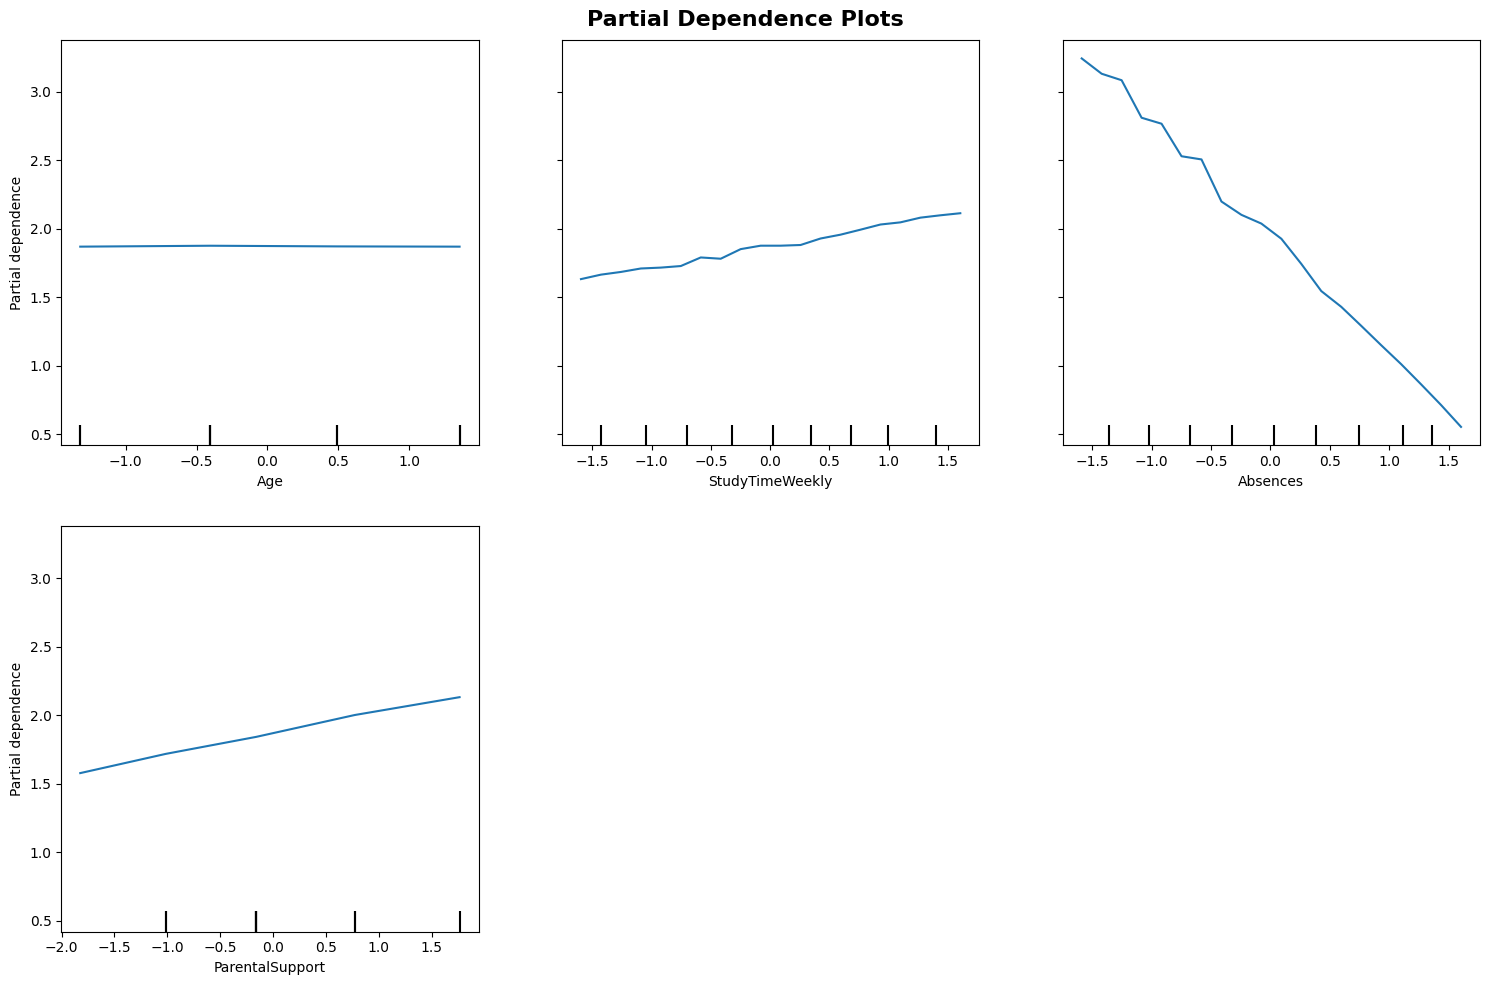

In [58]:
best_reg_model = reg_best_models.get('XGBoost', reg_best_models.get('RandomForest'))
fig, ax = plt.subplots(figsize=(15, 10))
top_features = feature_names[:min(4, X_train_processed.shape[1])]
PartialDependenceDisplay.from_estimator(
    best_reg_model,
    X_train_processed[:1000],
    features=top_features,
    feature_names=feature_names[:X_train_processed.shape[1]],
    ax=ax,
    grid_resolution=20
)
plt.suptitle('Partial Dependence Plots', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

**Model Evaluation**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


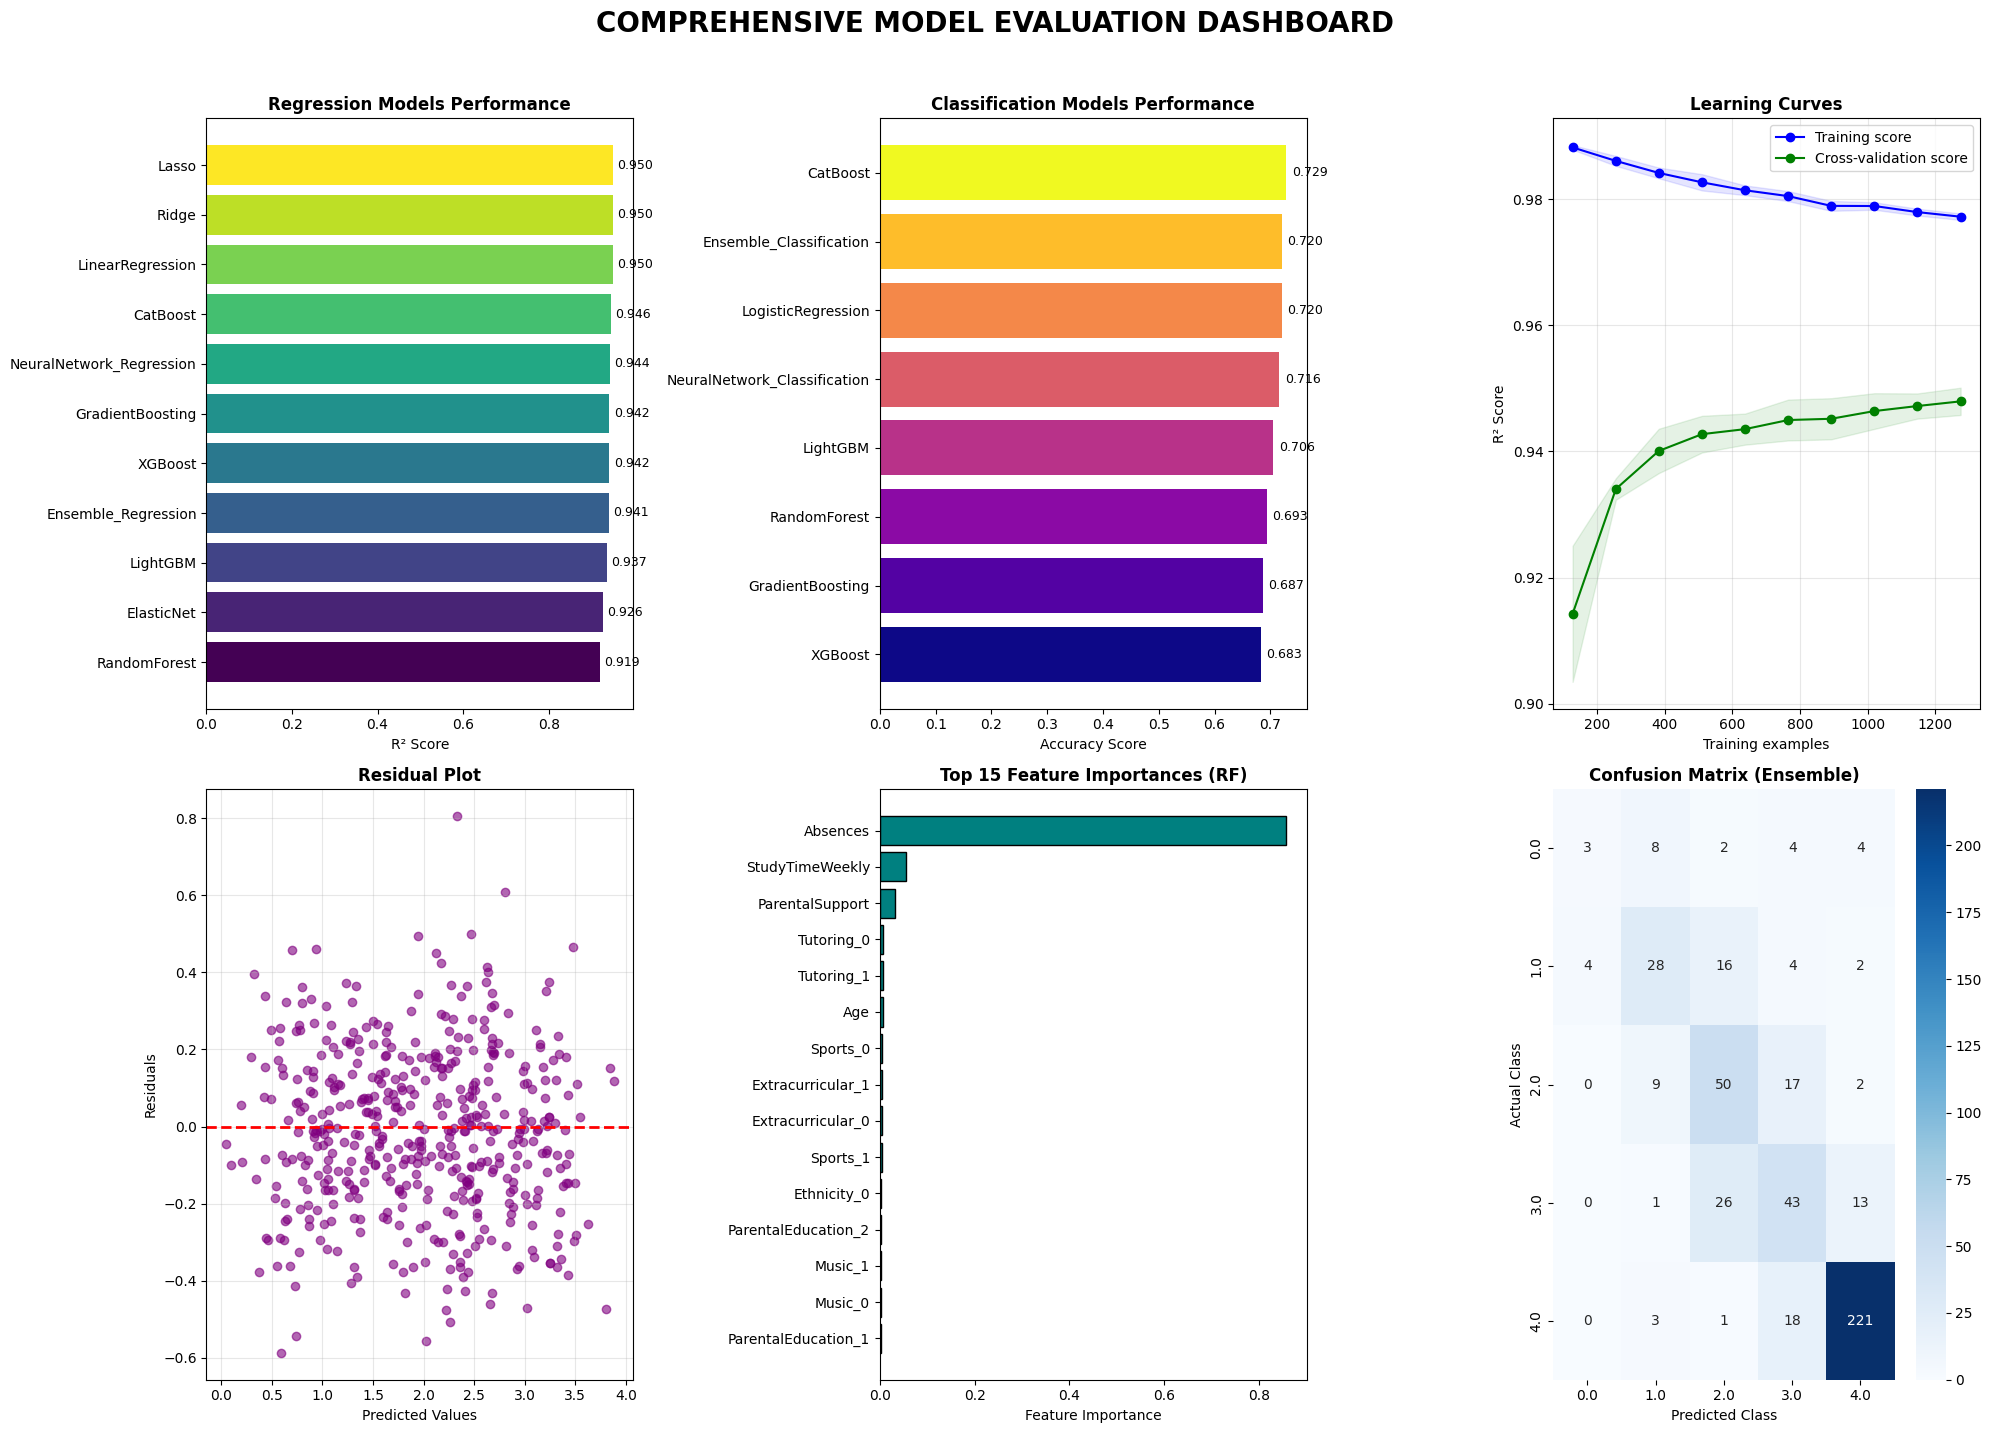

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))

#Regression Model Comparison
ax1 = axes[0, 0]
reg_comparison = reg_results_df[['Model', 'Test_R2', 'Test_RMSE']].copy()
reg_comparison.loc[len(reg_comparison)] = ensemble_reg_metrics
reg_comparison.loc[len(reg_comparison)] = nn_reg_metrics
reg_comparison = reg_comparison.sort_values('Test_R2', ascending=True)

bars = ax1.barh(reg_comparison['Model'], reg_comparison['Test_R2'],
                color=plt.cm.viridis(np.linspace(0, 1, len(reg_comparison))))
ax1.set_xlabel('R² Score')
ax1.set_title('Regression Models Performance', fontweight='bold')
for bar, score in zip(bars, reg_comparison['Test_R2']):
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', va='center', fontsize=9)


ax2 = axes[0, 1]
cls_comparison = cls_results_df[['Model', 'Test_Accuracy', 'Test_F1']].copy()
cls_comparison.loc[len(cls_comparison)] = ensemble_cls_metrics
cls_comparison.loc[len(cls_comparison)] = nn_cls_metrics
cls_comparison = cls_comparison.sort_values('Test_Accuracy', ascending=True)

bars = ax2.barh(cls_comparison['Model'], cls_comparison['Test_Accuracy'],
                color=plt.cm.plasma(np.linspace(0, 1, len(cls_comparison))))
ax2.set_xlabel('Accuracy Score')
ax2.set_title('Classification Models Performance', fontweight='bold')
for bar, score in zip(bars, cls_comparison['Test_Accuracy']):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', va='center', fontsize=9)



ax3 = axes[0, 2]
train_sizes, train_scores, test_scores = learning_curve(
    ensemble_regressor, X_train_processed, y_train_reg,
    cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

ax3.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
ax3.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
ax3.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
ax3.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
ax3.set_xlabel('Training examples')
ax3.set_ylabel('R² Score')
ax3.set_title('Learning Curves', fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 0]
y_pred_best = ensemble_regressor.predict(X_test_processed)
residuals = y_test_reg - y_pred_best

ax4.scatter(y_pred_best, residuals, alpha=0.6, c='purple')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot', fontweight='bold')
ax4.grid(True, alpha=0.3)

ax5 = axes[1, 1]
rf_model = reg_best_models.get('RandomForest')
if rf_model is not None:
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-15:]

    ax5.barh(range(len(indices)), importances[indices], color='teal', edgecolor='black')
    ax5.set_yticks(range(len(indices)))
    if len(feature_names) >= len(indices):
        ax5.set_yticklabels([feature_names[i] for i in indices])
    ax5.set_xlabel('Feature Importance')
    ax5.set_title('Top 15 Feature Importances (RF)', fontweight='bold')

ax6 = axes[1, 2]
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls_ensemble)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax6,
            xticklabels=sorted(np.unique(y_test_cls)),
            yticklabels=sorted(np.unique(y_test_cls)))
ax6.set_xlabel('Predicted Class')
ax6.set_ylabel('Actual Class')
ax6.set_title('Confusion Matrix (Ensemble)', fontweight='bold')

plt.suptitle('COMPREHENSIVE MODEL EVALUATION DASHBOARD',
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [60]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [61]:
class new_data_pipeline:
    def __init__(self):
        self.preprocessing_pipeline = full_pipeline
        self.regression_model = ensemble_regressor
        self.classification_model = ensemble_classifier
        self.scaler_reg = StandardScaler()
        self.scaler_cls = StandardScaler()
        self.engineered_features = [
            'TotalExtracurricular', 'StudyEfficiency', 'SupportScore',
            'TutoringImpact', 'Study_ParentSupport', 'Age_Study',
            'Absence_Performance', 'Tutoring_Support', 'StudyTime_squared',
            'Absences_squared', 'StudyTime_sqrt', 'Absences_log'
        ]
        self.engineer_features = engineer_features

    def preprocess(self, X):
        X_engineered = self.engineer_features(X)
        return self.preprocessing_pipeline.transform(X_engineered)

    def predict_gpa(self, X):
        X_processed = self.preprocess(X)
        return self.regression_model.predict(X_processed)

    def predict_grade(self, X):
        X_processed = self.preprocess(X)
        return self.classification_model.predict(X_processed)

    def predict_proba(self, X):
        X_processed = self.preprocess(X)
        return self.classification_model.predict_proba(X_processed)

    def get_feature_importance(self):
        if hasattr(self.regression_model, 'feature_importances_'):
            return self.regression_model.feature_importances_
        elif hasattr(self.regression_model.estimators_[0], 'feature_importances_'):
            importances = np.mean([est.feature_importances_
                                  for est in self.regression_model.estimators_], axis=0)
            return importances
        return None


In [62]:
new_data_pipeline = new_data_pipeline()

In [63]:
print("Testing New Data Pipeline...")
sample_data = pd.DataFrame({
    'Age': [16],
    'Gender': [1],
    'Ethnicity': [2],
    'ParentalEducation': [3],
    'StudyTimeWeekly': [18.5],
    'Absences': [3],
    'Tutoring': [1],
    'ParentalSupport': [4],
    'Extracurricular': [1],
    'Sports': [0],
    'Music': [1],
    'Volunteering': [1]
})
gpa_pred = new_data_pipeline.predict_gpa(sample_data)
grade_pred = new_data_pipeline.predict_grade(sample_data)
grade_proba = new_data_pipeline.predict_proba(sample_data)

print(f"Predicted GPA: {gpa_pred[0]:.2f}")
print(f"Predicted Grade: {grade_pred[0]}")
print(f"Predicted Probabilities: {grade_proba[0]}")

Testing New Data Pipeline...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Predicted GPA: 3.03
Predicted Grade: 1.0
Predicted Probabilities: [0.01899703 0.59426029 0.31393309 0.04640125 0.02640833]


In [64]:
def generate_report():
    best_reg_model_name = reg_results_df.iloc[0]['Model'] if not reg_results_df.empty else None

    importance_df = pd.DataFrame()

    if best_reg_model_name and best_reg_model_name in reg_best_models:
        best_model = reg_best_models[best_reg_model_name]
        if hasattr(best_model, 'feature_importances_'):
            importance_values = best_model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_names[:len(importance_values)],
                'Regression_Importance': importance_values
            }).sort_values('Regression_Importance', ascending=False)

    if importance_df.empty and 'importances' in globals() and hasattr(importances, 'head'):
        if hasattr(importances, 'columns') and 'feature' in importances.columns and 'importance' in importances.columns:
            importance_df = pd.DataFrame({
                'Feature': importances['feature'],
                'Regression_Importance': importances['importance']
            })
        elif hasattr(importances, 'index') and hasattr(importances, 'values'):
            importance_df = pd.DataFrame({
                'Feature': importances.index,
                'Regression_Importance': importances.values
            })

    if importance_df.empty:
        correlations = df[numeric_features].corrwith(df[target_reg]).abs().sort_values(ascending=False)
        importance_df = pd.DataFrame({
            'Feature': correlations.index,
            'Regression_Importance': correlations.values
        })

    report = {
        'dataset_info': {
            'n_samples': len(df),
            'n_features': X.shape[1],
            'targets': [target_reg, target_cls],
            'numeric_features': numeric_features,
            'categorical_features': categorical_features
        },
        'best_models': {
            'regression': {
                'model': best_reg_model_name,
                'test_r2': float(reg_results_df.iloc[0]['Test_R2']) if not reg_results_df.empty else 0,
                'test_rmse': float(reg_results_df.iloc[0]['Test_RMSE']) if not reg_results_df.empty else 0
            },
            'classification': {
                'model': cls_results_df.iloc[0]['Model'] if not cls_results_df.empty else 'N/A',
                'test_accuracy': float(cls_results_df.iloc[0]['Test_Accuracy']) if not cls_results_df.empty else 0,
                'test_f1': float(cls_results_df.iloc[0]['Test_F1']) if not cls_results_df.empty else 0
            }
        },
        'ensemble_performance': {
            'regression': ensemble_reg_metrics,
            'classification': ensemble_cls_metrics
        },
        'key_insights': {
            'top_features': importance_df.head(10).to_dict('records') if not importance_df.empty else [],
            'correlation_with_gpa': df[numeric_features].corrwith(df[target_reg]).to_dict(),
            'significant_factors': []
        },
        'recommendations': [
            "Focus on increasing weekly study time",
            "Implement absenteeism reduction programs",
            "Enhance parental involvement and support",
            "Promote music and extracurricular activities",
            "Provide targeted tutoring for at-risk students"
        ]
    }

    correlations = df[numeric_features].corrwith(df[target_reg])
    for feat, corr in correlations.items():
        if abs(corr) > 0.3:
            report['key_insights']['significant_factors'].append({
                'feature': feat,
                'correlation': float(corr),
                'impact': 'positive' if corr > 0 else 'negative'
            })

    return report


In [65]:
import json
report = generate_report()
with open('student_performance_report.json', 'w') as f:
    json.dump(report, f, indent=2)

In [66]:
print("key findings from analysis:")
for i, insight in enumerate(report['key_insights']['significant_factors'], 1):
    print(f"*{insight['feature']}*: {insight['impact']} impact (r = {insight['correlation']:.3f})")


key findings from analysis:
*Absences*: negative impact (r = -0.919)


In [67]:

print("recommendations: ")
for i, rec in enumerate(report['recommendations'], 1):
    print(f"{i}. {rec}")

recommendations: 
1. Focus on increasing weekly study time
2. Implement absenteeism reduction programs
3. Enhance parental involvement and support
4. Promote music and extracurricular activities
5. Provide targeted tutoring for at-risk students
